In [27]:
import random
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error
from qiskit.visualization import plot_histogram

import os
import pickle
from cryptography.hazmat.primitives.ciphers.aead import AESGCM

In [28]:
class SecureChannel:
    def __init__(self, key: bytes):
        """
        Initialize the secure channel with a shared symmetric key.
        Uses AES-GCM for both encryption (confidentiality) and authentication.
        """
        self.key = key
        self.aesgcm = AESGCM(key)
    
    def send(self, plaintext: bytes, associated_data: bytes = None):
        """
        Encrypts the plaintext using AES-GCM.
        Generates a new random 12-byte nonce for every encryption.
        Optionally authenticates the provided associated_data.
        Returns a tuple (nonce, ciphertext).
        """
        nonce = os.urandom(12)  # 96-bit nonce typical for AES-GCM.
        ciphertext = self.aesgcm.encrypt(nonce, plaintext, associated_data)
        return nonce, ciphertext
    
    def receive(self, nonce: bytes, ciphertext: bytes, associated_data: bytes = None):
        """
        Decrypts the provided ciphertext using AES-GCM and the given nonce.
        If the ciphertext or associated data has been tampered with,
        the decryption fails and an error is raised.
        """
        try:
            plaintext = self.aesgcm.decrypt(nonce, ciphertext, associated_data)
            return plaintext
        except Exception as e:
            print("Decryption failed or authentication error:", e)
            return None

    def send_object(self, obj, associated_data: bytes = None):
        """
        Serializes the given object to bytes using pickle, and then encrypts it.
        Returns the nonce and ciphertext.
        """
        obj_bytes = pickle.dumps(obj)
        return self.send(obj_bytes, associated_data)

    def receive_object(self, nonce: bytes, ciphertext: bytes, associated_data: bytes = None):
        """
        Decrypts the ciphertext to obtain the serialized object bytes, and then
        deserializes it using pickle.
        Returns the original Python object if successful, otherwise None.
        """
        obj_bytes = self.receive(nonce, ciphertext, associated_data)
        if obj_bytes is None:
            return None
        return pickle.loads(obj_bytes)

def main():
    # Generate a shared key (128 bits for this example; 256 bits can be used for stronger security)
    key = AESGCM.generate_key(bit_length=128)
    
    # Initialize the secure channel with the shared key.
    secure_channel = SecureChannel(key)
    
    # Define a sample Python object to be sent (e.g., a dictionary).
    message_object = {
        "message": "Hello, secure world!",
        "sender": "Alice",
        "priority": 1
    }
    associated_data = b"Channel auth data"
    
    # Sender serializes and encrypts the object.
    nonce, ciphertext = secure_channel.send_object(message_object, associated_data)
    print("Encrypted object sent:")
    print("Nonce:      ", nonce.hex())
    print("Ciphertext: ", ciphertext.hex())
    
    # Receiver decrypts and deserializes the object.
    received_object = secure_channel.receive_object(nonce, ciphertext, associated_data)
    print("\nDecrypted and deserialized object:")
    print(received_object)
    
    # Simulate tampering with the ciphertext.
    tampered_ciphertext = bytearray(ciphertext)
    tampered_ciphertext[0] ^= 1  # Modify a byte.
    print("\nTampered ciphertext:", bytes(tampered_ciphertext).hex())
    
    # Receiver's attempt to decrypt the tampered ciphertext.
    result = secure_channel.receive_object(nonce, bytes(tampered_ciphertext), associated_data)
    if result is None:
        print("\nTampering detected: Message authenticity compromised.")

if __name__ == '__main__':
    main()

Encrypted object sent:
Nonce:       2b24ea6697299cc02433ce25
Ciphertext:  0e1e53a12e07b26535a6956e811bc76d8ea2ac2f62943ef646054c0587faa3d9aa98a3195c8d16854581e05a97cabff374efe2c55c67967905300624cc432b49543454b6082cee17be955601e9acd51af0d6d2c35a2deeaa89148d5bed4648

Decrypted and deserialized object:
{'message': 'Hello, secure world!', 'sender': 'Alice', 'priority': 1}

Tampered ciphertext: 0f1e53a12e07b26535a6956e811bc76d8ea2ac2f62943ef646054c0587faa3d9aa98a3195c8d16854581e05a97cabff374efe2c55c67967905300624cc432b49543454b6082cee17be955601e9acd51af0d6d2c35a2deeaa89148d5bed4648
Decryption failed or authentication error: 

Tampering detected: Message authenticity compromised.


In [ ]:
class CascadeCorrection():
    def __init__(self, block_size):
        self.block_size = block_size
    def parity(block):
        return sum(block)%2
    def binary_search_correction(sender_block_parity, receiver_block, index=0):
        n = len(receiver_block)
        if n == 1:
            if sender_block_parity != receiver_block[index]:
                return index
        else:
            mid = n // 2
            receiver_left_block = receiver_block[index:mid]
            sender_left_block_parity = 0 # get from alice
            receiver_right_block = receiver_block[mid::]
            sender_right_block_parity = 0 # get from alice

            # if parity(left_receiver_block) != alice_left_block_parity:




In [30]:
np.random.seed(439)
bits = np.array([0,1,1,1,1,0,0,0,1,0,1,0,1,0])
indices = np.array([i for i in range(len(bits))])
shuffle1 = indices.copy()
np.random.shuffle(shuffle1)
print(indices)
print(shuffle1)
indices[shuffle1[[0,3]]]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 9  8  6  2  3  0 11 10  5 12  7  1 13  4]


array([9, 2])

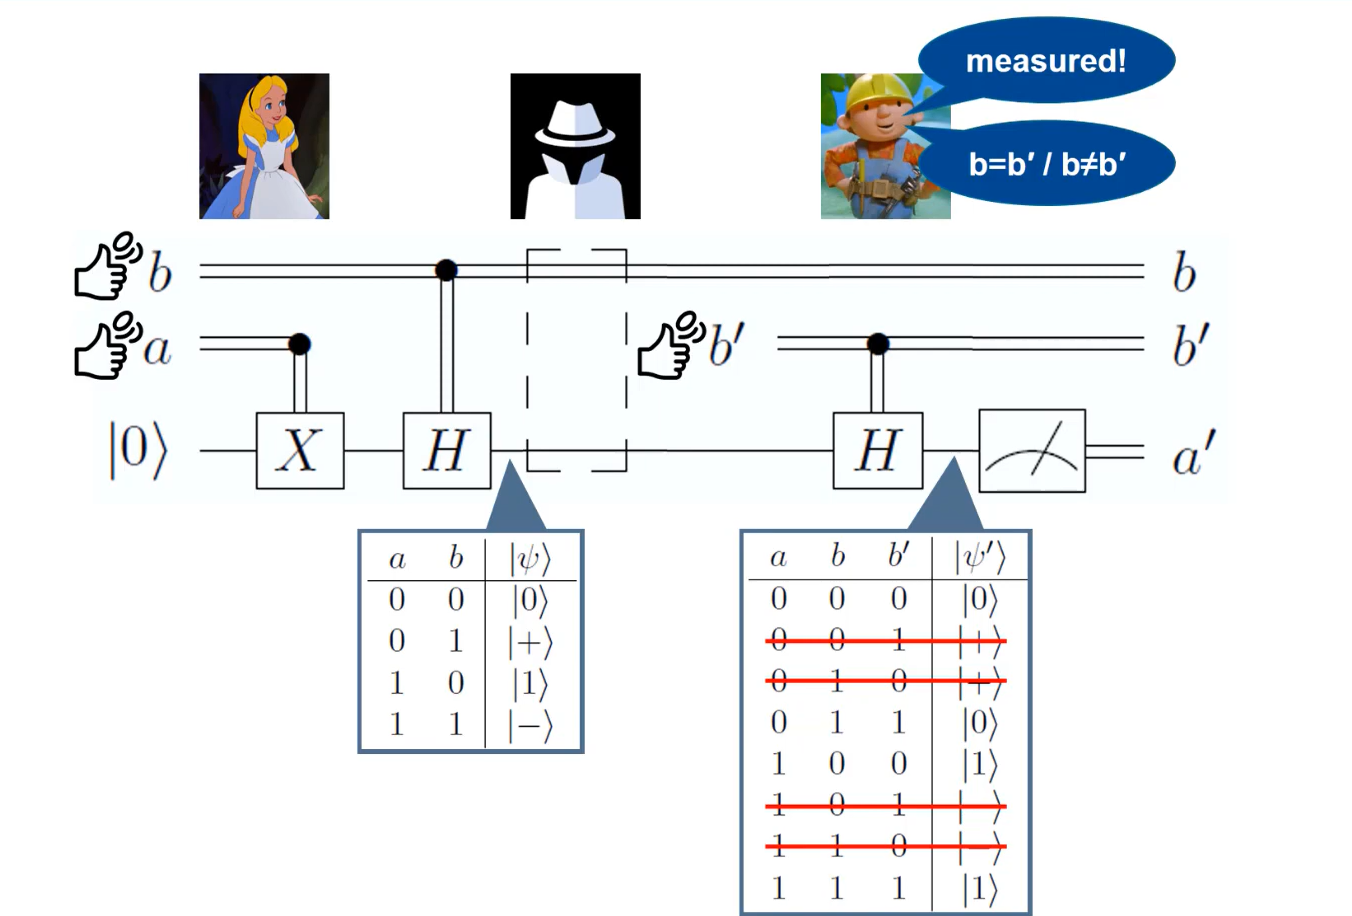

In [31]:
class Sender():
    qubit = 0
    raw_key = []
    sifted_key = []
    filtered_key = []
    basis = [] # 0 for 0,1 Basis and 1 for +,- basis
    receiver_basis = []
    verification_indices = {}
    verification_set = {}
    receiver_verification_set = {} 
    key = AESGCM.generate_key(bit_length=128)
    np.random.seed(key[(len(key)//2)]) 
    secure_channel = SecureChannel(key)
    associated_data = b"BB84 Secure Channel Integrity"

    def __init__(self,s):
        self.s = s

    def start_secure_channel(self):
        return [self.secure_channel,self.associated_data]

    def prepare(self):
        self.qubit = QuantumCircuit(1,1)
        a = np.random.randint(0,2)
        b = np.random.randint(0,2)
        if a:
            self.qubit.x(0)
        if b:
            self.qubit.h(0)
        self.raw_key.append(a)
        self.basis.append(b)

    def send_qubit(self):
        return self.qubit
    
    def send_basis(self):
        return self.secure_channel.send_object(self.basis, self.associated_data)

    def receive_basis(self, encrypted_receiver_basis):
        nonce, ciphar_receiver_basis = encrypted_receiver_basis
        self.receiver_basis = self.secure_channel.receive_object(nonce,ciphar_receiver_basis,self.associated_data)
    
    def sift_key(self):
        n = len(self.raw_key)
        self.sifted_key = [self.raw_key[i] for i in range(n) if self.basis[i] == self.receiver_basis[i]]
    
    def generate_verification_indices(self):
        n = len(self.sifted_key)
        self.verification_indices = set(random.sample([i for i in range(n)],k=self.s))

    def send_verification_indices(self):
        return self.secure_channel.send_object(self.verification_indices, self.associated_data)
    
    def calculate_verification_set(self):
        self.verification_set = [self.sifted_key[bit_index] for bit_index in self.verification_indices]
    
    def send_verification_set(self):
        return self.secure_channel.send_object(self.verification_set, self.associated_data)
    
    def receive_verification_set(self, encrypted_receiver_verification_set):
        nonce, ciphar_receiver_verification_set = encrypted_receiver_verification_set
        self.receiver_verification_set = self.secure_channel.receive_object(nonce,ciphar_receiver_verification_set,self.associated_data)

    def is_same_verification_set(self):
        return self.verification_set == self.receiver_verification_set

    # def filter_sifted_key(self):
        

    def is_same_key(self, reciever_sifted_key):
        return self.sifted_key == reciever_sifted_key   

In [ ]:
class Reciever():
    simulator = AerSimulator()
    qubit = -1
    raw_key = []
    sifted_key = []
    basis = [] # 0 for 0,1 Basis and 1 for +,- basis
    sender_basis = []
    verification_indices = {}
    verification_set = {}

    # def __init__(self, with_error):
    #     pass

    def accept_secure_channel(self, channel_parameters):
        self.secure_channel = channel_parameters[0]
        self.associated_data = channel_parameters[1]
        key = self.secure_channel.key
        np.random.seed(key[(len(key)//2)]) 

    def recieve_qubit(self, qubit):
        self.qubit = qubit
        # nonce, cipher_qubit = message
        # self.qubit = self.secure_channel.receive_object(nonce, cipher_qubit, self.associated_data)
    
    def prepare(self):
        b = np.random.randint(0,2)
        if b:
            self.qubit.h(0)
        self.basis.append(b)

    def measure(self):
        self.qubit.measure(0,0)
        result = self.simulator.run(self.qubit, shots = 1024).result()
        results_dictionary = result.get_counts()
        measured_qubit = 1
        if '0' in results_dictionary and '1' in results_dictionary:
            one_counts = results_dictionary['1']
            measured_qubit = one_counts/(one_counts+results_dictionary['0'])
        elif '0' in results_dictionary:
            measured_qubit = 0
        self.raw_key.append(measured_qubit)

    def send_basis(self):
        return self.secure_channel.send_object(self.basis, self.associated_data)

    def receive_basis(self, encrypted_sender_basis):
        nonce, ciphar_sender_basis = encrypted_sender_basis
        self.sender_basis = self.secure_channel.receive_object(nonce,ciphar_sender_basis,self.associated_data)

    def sift_key(self):
        n = len(self.raw_key)
        self.sifted_key = [self.raw_key[i] for i in range(n) if self.basis[i] == self.sender_basis[i]]

    def recieve_verification_indices(self, encrypted_verification_indices):
        nonce, ciphar_verification_indices = encrypted_verification_indices
        self.verification_indices = self.secure_channel.receive_object(nonce,ciphar_verification_indices,self.associated_data)

    def calculate_verification_set(self):
        self.verification_set = [self.sifted_key[bit_index] for bit_index in self.verification_indices]
    
    def send_verification_set(self):
        return self.secure_channel.send_object(self.verification_set, self.associated_data)
    
    def receive_verification_set(self, encrypted_sender_verification_set):
        nonce, ciphar_sender_verification_set = encrypted_sender_verification_set
        self.sender_verification_set = self.secure_channel.receive_object(nonce,ciphar_sender_verification_set,self.associated_data)

    def is_same_verification_set(self):
        return self.verification_set == self.sender_verification_set
    
    def request_parities(self, block_indices, shuffle):
        return self.secure_channel.send_object(block_indices, self.associated_data)
        
    
    def binary_search_correction(self,sender_block_parity, receiver_block, start_index=0):
        n = len(receiver_block)
        if n == 1:
            if sender_block_parity != receiver_block[start_index]:
                return start_index
        else:
            mid = n // 2
            receiver_left_block = receiver_block[:mid]
            sender_left_block_parity = 0 # get from alice
            receiver_right_block = receiver_block[mid:]
            sender_right_block_parity = 0 # get from alice

            if sum(receiver_left_block)%2 != sender_left_block_parity:
                return self.binary_search_correction(sender_left_block_parity,receiver_left_block,start_index)
            else:
                return self.binary_search_correction(sender_left_block_parity,receiver_left_block,start_index+mid)

In [33]:
key = AESGCM.generate_key(bit_length=128)
len(key)

16

In [34]:
# class Evesdropper():

In [ ]:
class BB84():
    alice = None
    bob = None
    trudy = None
    
    def __init__(self, e = 1e-11, d = 1e-1, with_evesdropper = False, with_qerror = False):
        self.with_evesdropper = with_evesdropper
        self.with_qerror = with_qerror
        # e = 1e-11# error rate
        # d = 1e-1# tolerance on the error rate estimation
        s =  int(np.ma.log2(2/e)//(2*d**2)) # the number of bits 𝑠 to be sacrificed for error estimation
        self.n = int(2**(np.ma.log2(s)+4))
        self.alice = Sender(s)
        self.bob = Reciever()
        #self.trudy = Evesdropper

    def start(self):
        for i in range(self.n):
            self.alice.prepare()
            qubit = self.alice.send_qubit()
            self.bob.recieve_qubit(qubit)
            self.bob.prepare()
            self.bob.measure()
        secure_channel = self.alice.start_secure_channel()
        self.bob.accept_secure_channel(secure_channel)
        alice_basis = self.alice.send_basis()
        self.bob.receive_basis(alice_basis)
        bob_basis = self.bob.send_basis()
        self.alice.receive_basis(bob_basis)
        self.alice.sift_key()
        self.bob.sift_key()
        self.alice.generate_verification_indices()
        verification_indices = self.alice.send_verification_indices()
        self.alice.calculate_verification_set()
        self.bob.recieve_verification_indices(verification_indices)
        self.bob.calculate_verification_set()
        alice_verification_set = self.alice.send_verification_set()
        self.bob.receive_verification_set(alice_verification_set)
        bob_verification_set = self.bob.send_verification_set()
        self.alice.receive_verification_set(bob_verification_set)
        print("Alice Basis:",self.alice.basis)
        print("Bob Basis:",self.bob.basis)
        print("Verification Indices:",self.alice.verification_indices)
        print("Alice Verification Set:",self.alice.verification_set)
        print("Bob Verification Set:",self.bob.verification_set)
        print(self.alice.is_same_verification_set() and self.bob.is_same_verification_set())

In [36]:
bb84 = BB84()
bb84.start()

Alice Basis: [1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,

In [37]:
qubit = QuantumCircuit(1,1)
simulator = AerSimulator()
qubit.h(0)
qubit.measure(0,0)
result = simulator.run(qubit, shots = 1024).result()
results_dictionary = result.get_counts()
measured_qubit = 1
if '0' in results_dictionary and '1' in results_dictionary:
    one_counts = results_dictionary['1']
    measured_qubit = one_counts/(one_counts+results_dictionary['0'])
elif '0' in results_dictionary:
    measured_qubit = 0
measured_qubit

0.501953125

# BB84 With no evesdropper and no error

# BB84 With evesdropper and no error

# BB84 With error and no evesdropper

# BB84 With error and evesdropper